In [530]:
import datetime
import importlib
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import utils
from utils.download import get_data
from utils.var import calculate_var, exceeds_vector
from utils.methods import weighted_var, garch_var

In [531]:
_ = importlib.reload(utils.download)

In [532]:
data, params = get_data()

[*********************100%%**********************]  1 of 1 completed


In [533]:
data['returns'] = data.interpolate(type='linear').pct_change()

In [534]:
train, test = data.loc[:params['test']-datetime.timedelta(days=1), ], data.loc[params['test']:, ]

# Metoda historyczna

In [535]:
alpha = .95

In [537]:
data = calculate_var(data, lambda x: np.quantile(x, alpha), 'hist')

Wykres zwrotów i VaR95 dla zwrotów.

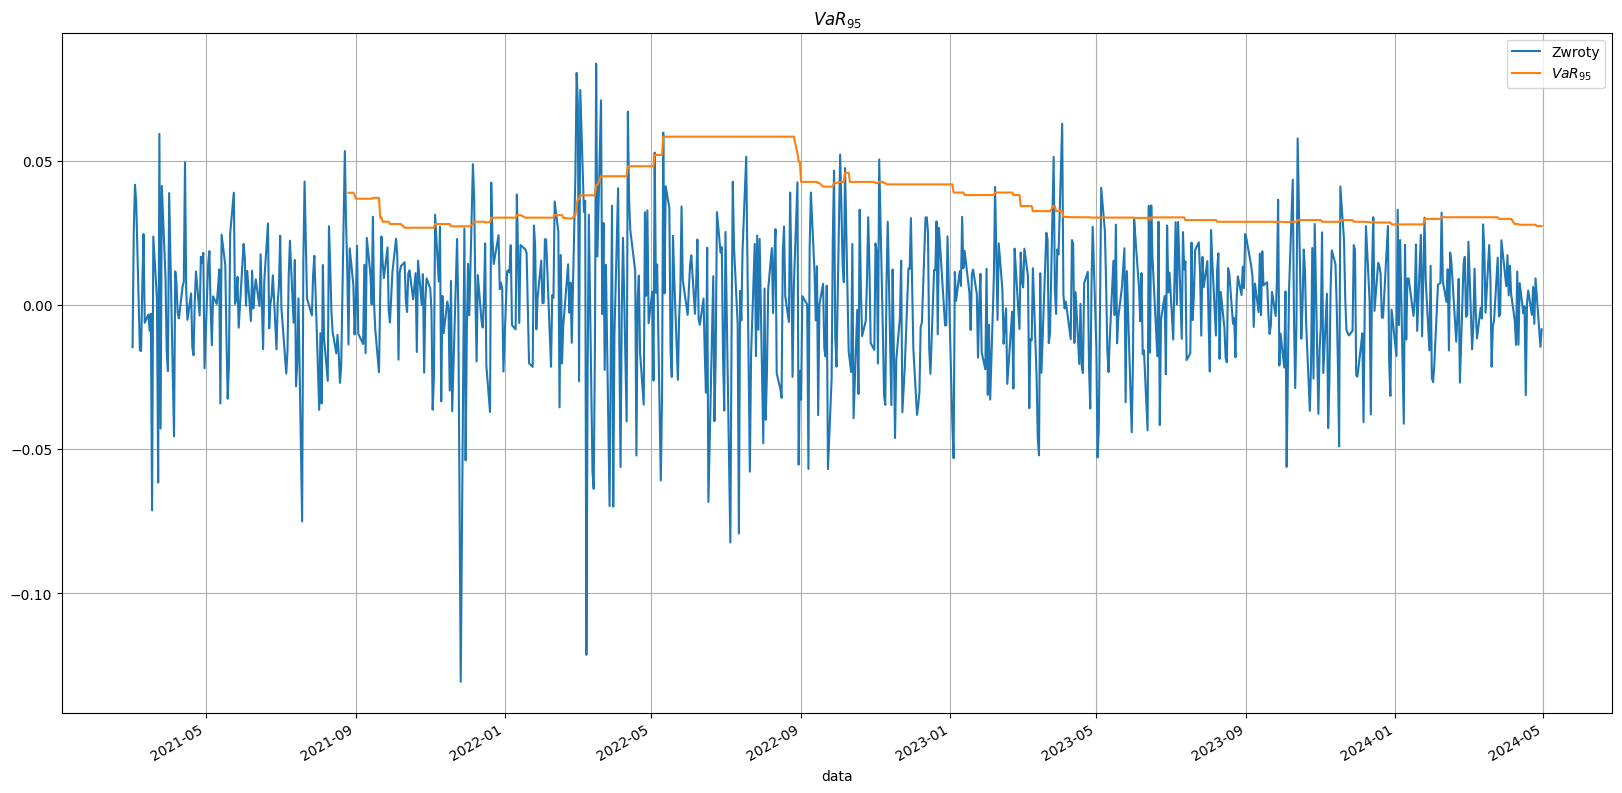

In [538]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95.png")

Wykres cen i VaR95 dla cen.

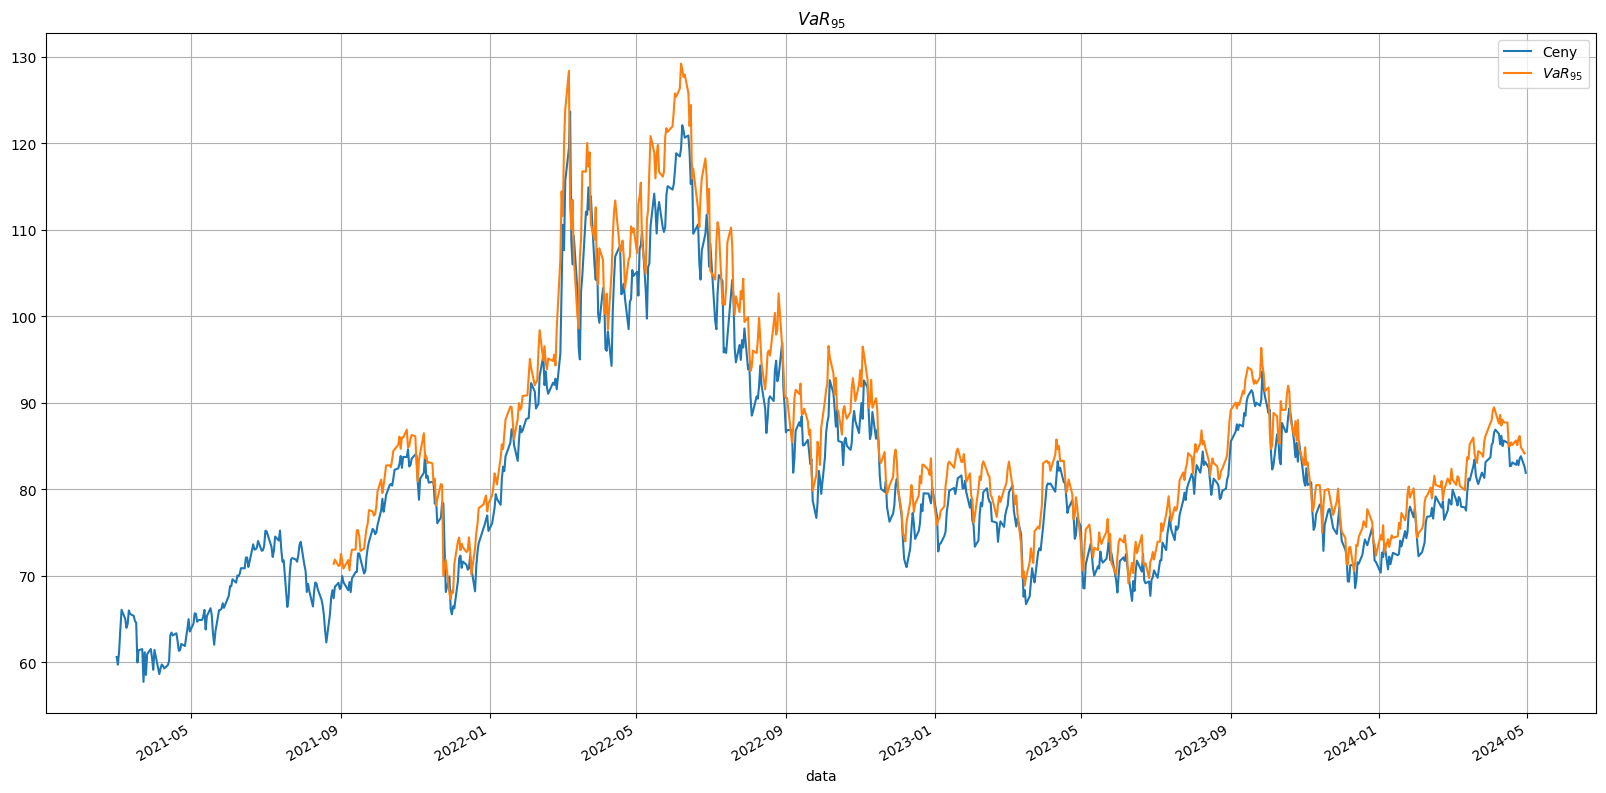

In [539]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['Close', 'VaR95_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Ceny', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95_ceny.png")

In [540]:
data, I = exceeds_vector(data, 'hist')

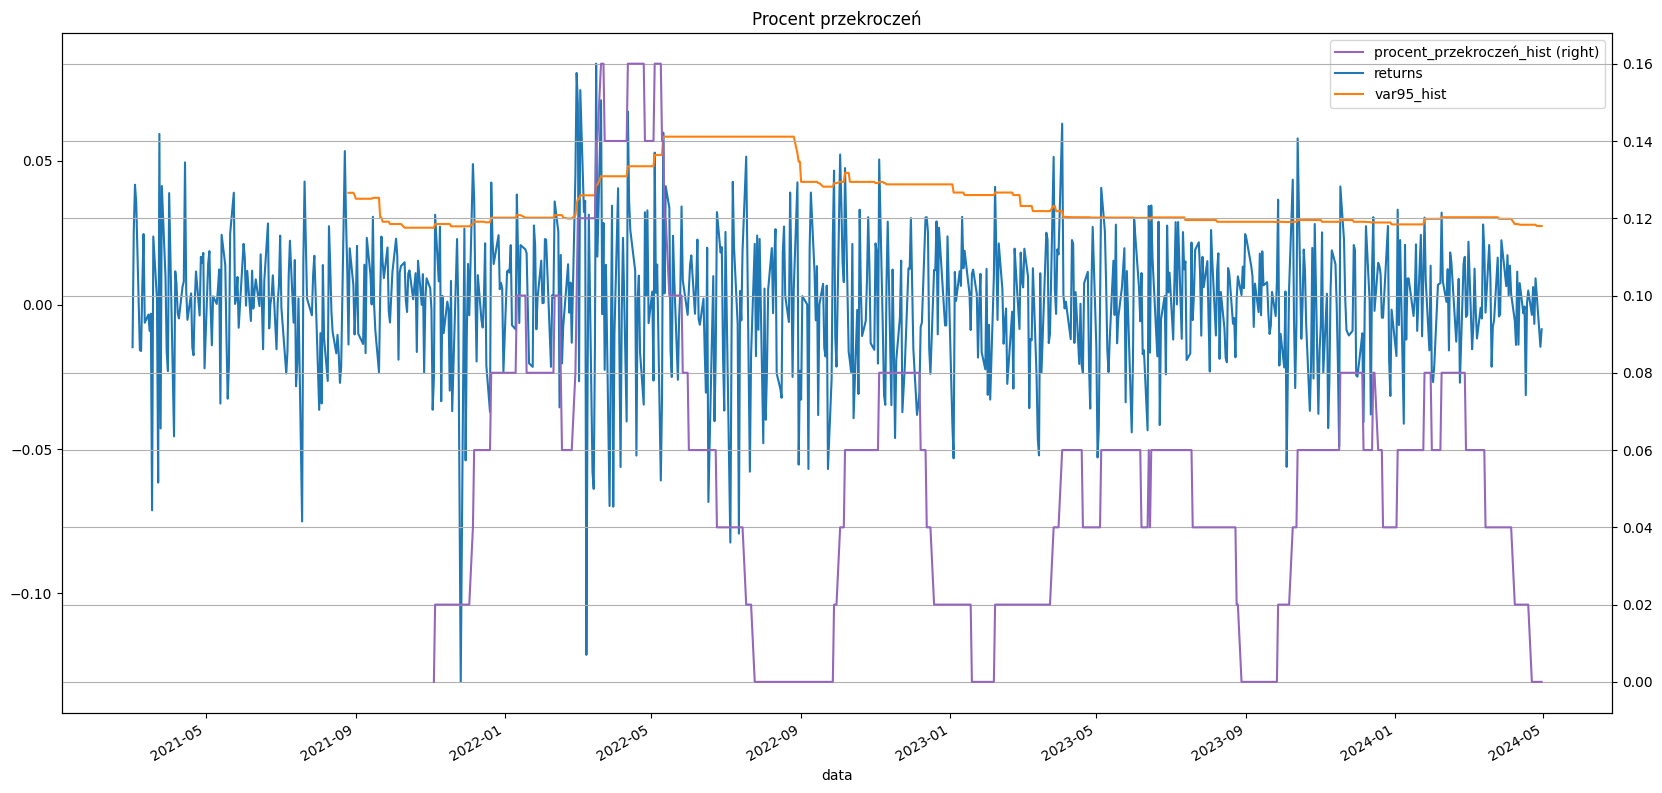

In [542]:
_, ax = plt.subplots(figsize=(20,10))
line1 = data[['procent_przekroczeń_hist']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_hist']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C1'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [543]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'.\
    format(*map(lambda x: np.round(x, 3),
                [I.mean(), alpha, 1- alpha,
                 I.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.053, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.05, 0.95(1 - 0.95) = 0.048.


In [544]:
stats.binomtest(int(I.sum()), n=I.size, p=1-alpha)

BinomTestResult(k=33, n=624, alternative='two-sided', statistic=0.052884615384615384, pvalue=0.713077314362375)

# Metoda ważonej symulacji historycznej

In [545]:
lam = params['lambda']
alpha = 0.95

In [547]:
data = calculate_var(data, weighted_var, 'ważona')

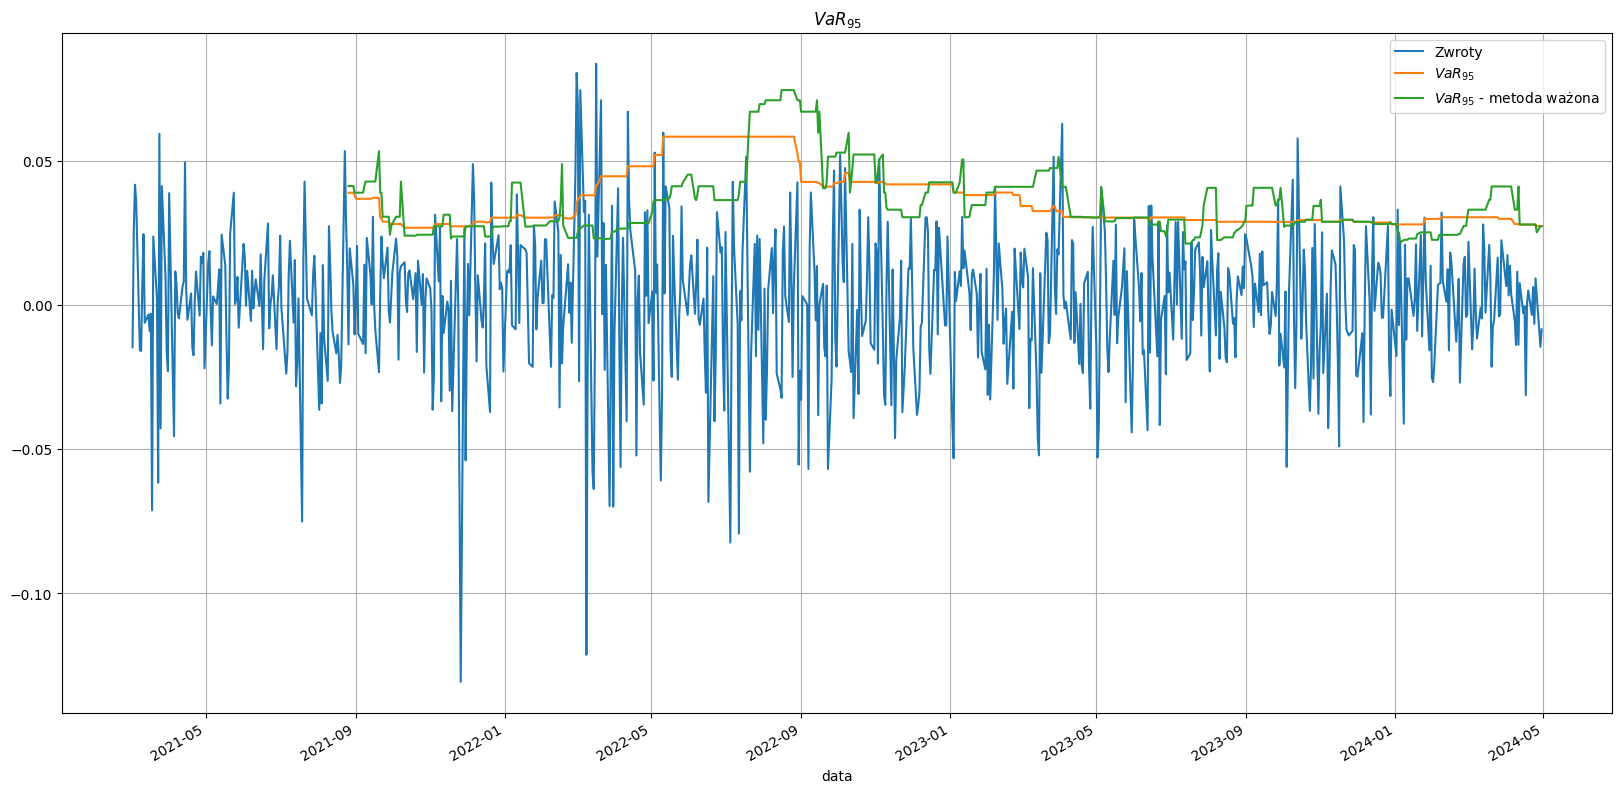

In [548]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist','var95_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona'])
plt.savefig(f'pics\\{params["name"]}\\var95_wazony.png')

In [549]:
data, I_weighted = exceeds_vector(data, 'ważona')

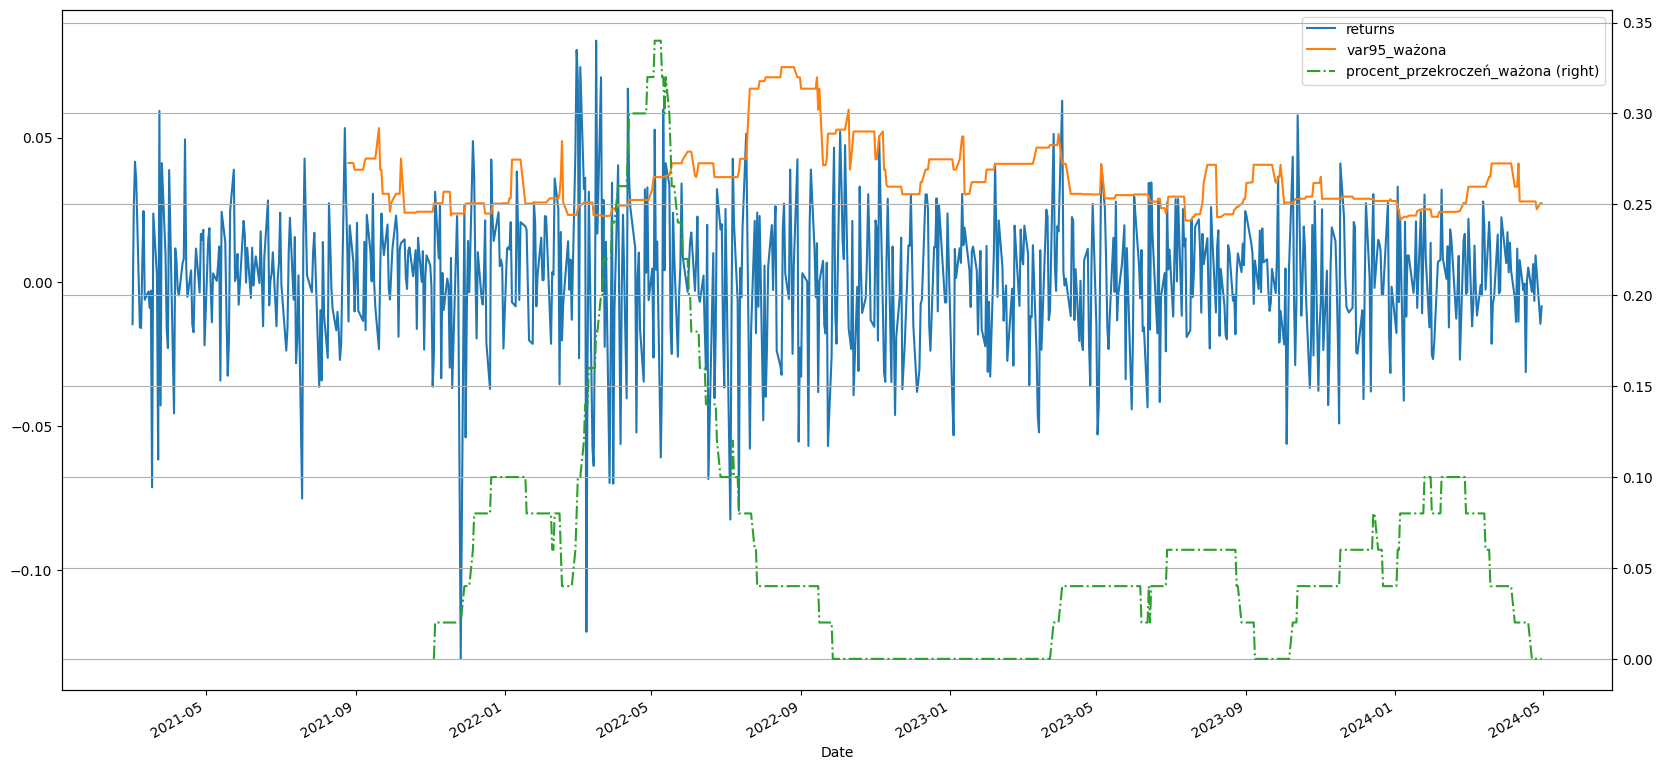

In [550]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważona', 'procent_przekroczeń_ważona']].plot(ax=ax,
                                                                         secondary_y=['procent_przekroczeń_ważona'],
                                                                         grid=True,
                                                                         style=['-', '-', '-.'])

## Testowanie wsteczne

### Rozkład dwumianowy

In [551]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_weighted.mean(), alpha, 1 - alpha,
                   I_weighted.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.064, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.06, 0.95(1 - 0.95) = 0.048.


In [552]:
stats.binomtest(int(I_weighted.sum()), n=I_weighted.size, p=1-alpha)

BinomTestResult(k=40, n=624, alternative='two-sided', statistic=0.0641025641025641, pvalue=0.1172789788139323)

# Metoda filtrowanej symulacji historycznej

In [555]:
%%capture
data = calculate_var(data, garch_var, 'garch')

In [556]:
data, I_garch = exceeds_vector(data, 'garch')

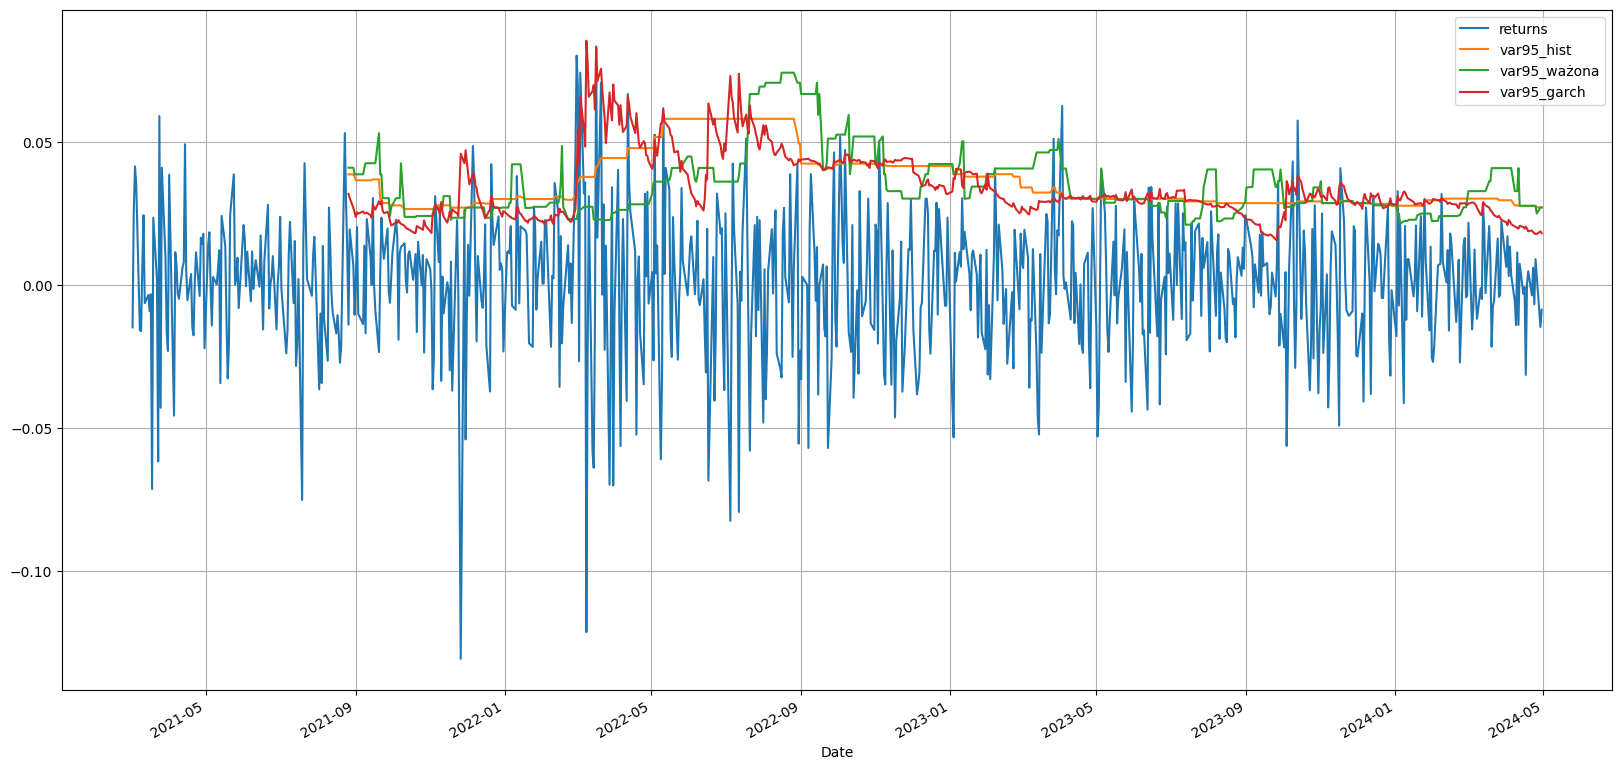

In [558]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_hist', 'var95_ważona', 'var95_garch']].plot(grid=True, ax=ax)

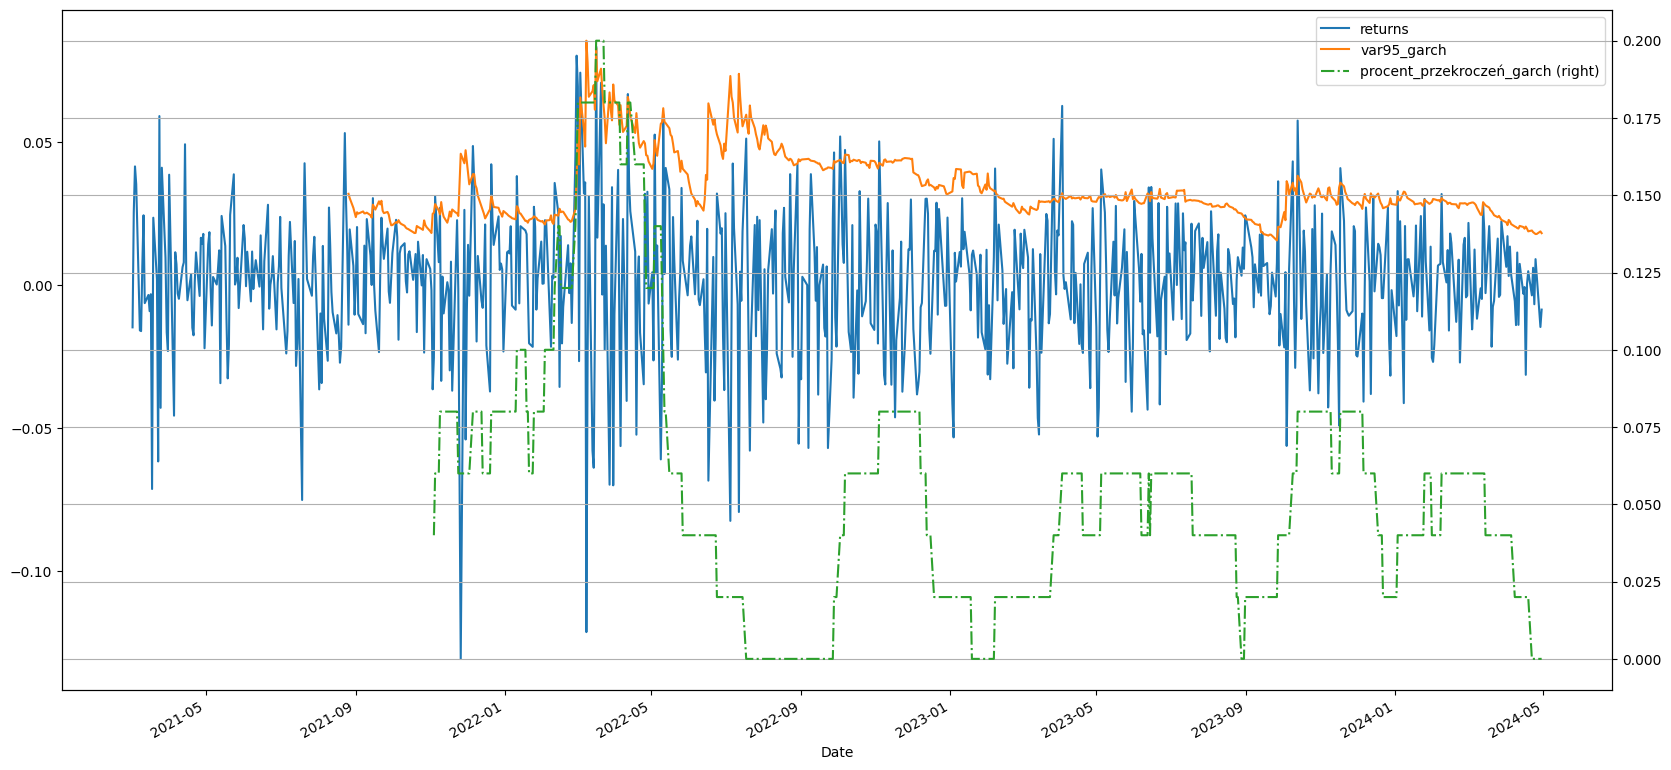

In [559]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_garch', 'procent_przekroczeń_garch']]. \
    plot(ax=ax, secondary_y=['procent_przekroczeń_garch'], grid=True,
         style=['-', '-', '-.'])

## Testowanie wsteczne

### Rozkład dwumianowy

In [ ]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_garch.mean(), alpha, 1 - alpha,
                   I_garch.var(), alpha, alpha, alpha * (1 - alpha)])))

In [ ]:
stats.binomtest(int(I_garch.sum()), n=I_garch.size, p=1-alpha)